In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import os 
os.chdir("/Users/michaelyang/Desktop/NYU/2017.Spring/Machine Learning/Project/ml_applications_for_the_nba/")

In [15]:
df = pd.read_csv('final_clean.csv').sort_values('GAME_ID')
df = df.dropna()
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE_HOME'])
#df = df.set_index('GAME_ID')

# Define a target column
df['AVG_SPREAD_mean'] = df['PLUS_MINUS_mean_HOME'] - df['PLUS_MINUS_mean_AWAY']
df['ACTUAL_SPREAD'] = df['PLUS_MINUS_HOME']

In [16]:
def select_season(season):
    prefix = {'2012-13':'212', '2013-14':'213', '2014-15':'214',
             '2015-16':'215', '2016-17':'216'}
    return df[df['GAME_ID'].astype(str).str.startswith(prefix[season])]

def select_seasons(seasons):
    result = pd.DataFrame()
    for season in seasons:
        result = pd.concat([result, select_season(season)])
    return result

df_train = select_seasons(['2012-13','2013-14','2014-15'])
df_val = select_seasons(['2015-16'])
df_test = select_seasons(['2016-17'])

df_train_avg = copy.deepcopy(df_train["AVG_SPREAD_mean"].as_matrix())
df_val_avg = copy.deepcopy(df_val["AVG_SPREAD_mean"].as_matrix())

In [17]:
# Preprocessing here
from sklearn.preprocessing import StandardScaler

numerical_cols = [c for c in df_train.columns if 'mean' in c or 'avg' in c and 'PLUS_MINUS' not in c and 'AVG_SPREAD' not in c]

for col in numerical_cols:
    scl = StandardScaler()
    df_train[col] = scl.fit_transform(df_train[col].as_matrix().reshape(-1,1)) # may want to fit on both validation and train
    # assign val and test
    df_val[col] = scl.transform(df_val[col].as_matrix().reshape(-1,1))
    df_test[col] = scl.transform(df_test[col].as_matrix().reshape(-1,1))

In [18]:
def betting_metric(y_pred, y_actual):
    # +1 for good outcome, -1 for bad outcome
    return (2*(y_pred < y_actual).astype(int) - 1)

# quick test 
betting_metric(np.array([2,3,-3,-2]),np.array([3,2,-2,-3]))

array([ 1, -1,  1, -1])

In [19]:
# One metric is fraction correct (accuracy score)
def fraction_correct(y_pred, y_actual):
    # print y_pred.shape
    counts =  pd.Series(betting_metric(y_pred, y_actual).ravel()).value_counts()
    return float(counts.loc[1])/counts.sum()

# This is the "base modeL"
print betting_metric(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME']).mean()
print betting_metric(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME']).value_counts()

print fraction_correct(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME'])
# Not meaningful, but interesting to see whether AWAY point spread helps.
# print betting_metric(df['PLUS_MINUS_mean_HOME'], df['PLUS_MINUS_HOME']).mean()

0.172880237545
 1    3555
-1    2507
dtype: int64
0.586440118773


In [20]:
numerical_cols = list(set(numerical_cols) - set(['PLUS_MINUS_mean_AWAY', 'PLUS_MINUS_mean_HOME','ACTUAL_SPREAD']))

In [21]:
from sklearn.linear_model import LinearRegression, Lasso

X_train = df_train[numerical_cols].as_matrix()
y_train = df_train['ACTUAL_SPREAD'].as_matrix().reshape(-1,1)
X_val = df_val[numerical_cols].as_matrix()
y_val = df_val['ACTUAL_SPREAD'].as_matrix()#.reshape(-1,1)
X_test = df_test[numerical_cols].as_matrix()
y_test = df_test['ACTUAL_SPREAD'].as_matrix().reshape(-1,1)


linreg = LinearRegression()
lasso = Lasso(alpha=0.1)
linreg.fit(X_train, y_train)
lasso.fit(X_train, y_train)
#print linreg.coef_
print "Linear model"
y_train_pred = linreg.predict(X_train)
print np.array([np.sign(linreg.predict(X_val)) == np.sign(y_val)]).astype(int).mean()

print ""
print "Lasso"
y_train_pred = lasso.predict(X_train)
print fraction_correct(linreg.predict(X_val), y_val)
print np.sum(lasso.coef_==0).astype(float) / lasso.coef_.shape[0]

Linear model
0.535796255052

Lasso
0.500618131821
0.672


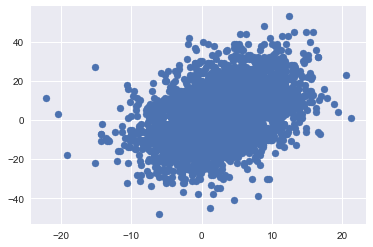

In [22]:
plt.scatter(y_train_pred, y_train)

Random Forest


0.500760336708


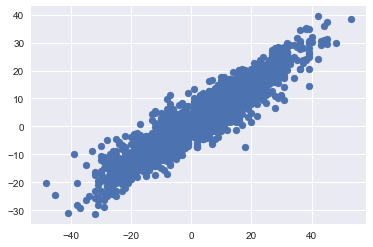

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor() # todo: hyperparameter search...

rf.fit(X_train, y_train.ravel())
print "Random Forest"
y_train_pred = rf.predict(X_train)
print fraction_correct(y_train_pred, y_train)
plt.scatter(y_train, y_train_pred)

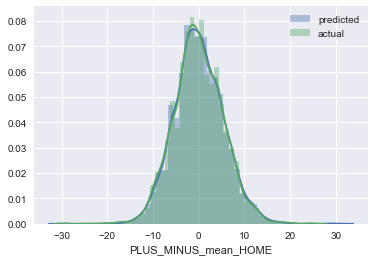

In [24]:
sns.distplot(df['PLUS_MINUS_mean_AWAY'].dropna(), label='predicted')
sns.distplot(df['PLUS_MINUS_mean_HOME'].dropna(), label='actual')
plt.legend()

In [25]:
# give a range which the prediction can be away from actual
def evaluate_prediction(y_pred,y_actual):
    
    delta = 10 # the range
    score = np.logical_and((y_pred < y_actual),\
    (y_pred > y_actual-delta)).astype(float)
    
    return sum(score)/len(score)
# evaluate_prediction(np.array([-1,-2,-5]),np.array([11,3,-10])) test

In [26]:
import xgboost as xgb
from  functools import partial

dtrain = xgb.DMatrix(X_train,(y_train))
param = {'max_depth': 4, 'silent': 1}
num_round = 150

def learn_rate(n,t_n):
    return 1/(np.sqrt(n+.1))

def hinge(preds, dtrain):
    labels = dtrain.get_label()
    m = len(labels)
    a =  (labels <= preds).astype(int)
    # print preds
    # print(a[10:30])
    return a*np.ones(m), np.zeros(m)


def log(preds,dtrain):
    labels = dtrain.get_label()
    m = labels*preds
    return 1/(1+np.exp(m)) , 1/(np.exp(-m/2)+np.exp(m/2))**2

def softmax(preds,dtrain):
    labels = dtrain.get_label()
    m = labels - preds
    return 1/(np.exp(-m/2)+np.exp(m/2))**2, \
            2/(np.exp(-2*m/3)+np.exp(m/3))**3 \
                - 1/(np.exp(-m/2)+np.exp(m/2))**2

def skewed_sq(preds, dtrain,skewness,flat_region):
    labels = dtrain.get_label()
    b = skewness
    spread = flat_region
    a = (1)*(preds>labels) + \
            b*(preds<= labels-spread)
    return a*(preds - labels), a*np.ones(len(labels))

In [27]:
# finding optimal parameter
# for skew in [0.1,0.2,0.3]:
#     for flat in [3,4,5]:
#         skewed_sq = partial(skewed_sq,skewness = skew, flat_region = flat)
#         bst = xgb.train(params=param, dtrain=dtrain, num_boost_round=num_round, obj \
#                 = skewed_sq)
#         BT = bst.predict(xgb.DMatrix(X_val))
#         plt.scatter(BT,(y_val))
#         plt.plot(np.arange(-40,40),np.arange(-40,40),c = "y")
#         plt.show()
#         print "flat= ",flat,"skew= ",skew, evaluate_prediction(BT,y_val)

In [28]:
# BT = bst.predict(xgb.DMatrix(X_val))
# plt.scatter(BT,(y_val))
# plt.plot(np.arange(-40,40),np.arange(-40,40),c = "y")
# # fraction_correct(bst.predict(xgb.DMatrix(X_val)),(y_val))
# evaluate_prediction(bst.predict(xgb.DMatrix(X_val)),y_val)

In [80]:
# Spread classification data
X_train_spread = df_train[numerical_cols].drop(["AVG_SPREAD_mean"],1).as_matrix()
X_val_spread = df_val[numerical_cols].drop(["AVG_SPREAD_mean"],1).as_matrix()

y_train_spread = np.sign(y_train.reshape(-1) - \
                 df_train_avg)
y_val_spread = np.sign(y_val.reshape(-1) - \
                 df_val_avg)

In [30]:
# Logistic regression on W/L
from sklearn.linear_model import LogisticRegression
LogR = LogisticRegression()
LogR.fit(X_train,np.sign(y_train).reshape(-1))
np.array([LogR.predict(X_train)==np.sign(y_train).reshape(-1)]).astype(int).mean()

0.67702888583218712

In [31]:
# On covering spread
LogR_s = LogisticRegression()
LogR_s.fit(X_train_spread,y_train_spread)
np.array(LogR_s.predict(X_val_spread)==y_val_spread).astype(int).mean()

0.596042868920033

In [32]:
# SVM on W/L
from sklearn.svm import LinearSVC as svm

for c in [0.01]:
    SVM = svm(C=c,penalty='l2',loss='hinge')
    SVM.fit(X_train,np.sign(y_train).reshape(-1))
    print 'c = ',c, (SVM.predict(X_val) == np.sign(y_val).reshape(-1)).astype(int).mean()

c =  0.01 0.682605111294


In [230]:
#svm with spread classification
SVM_s = svm(C=0.001,penalty='l2',loss='hinge')
SVM_s.fit(X_train_spread,y_train_spread)
(SVM_s.predict(X_val_spread)==y_val_spread).astype(int).mean()

0.60098928276999175

60


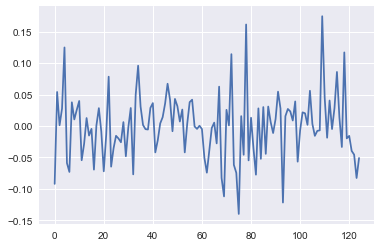

In [34]:
# Roughly how many non-suport vectors
plt.plot(np.arange(0,len(SVM.coef_.reshape(-1)),1),SVM.coef_.reshape(-1))
# number of features that are zeros
print sum(SVM.coef_.reshape(-1) < 10**-5)

In [154]:
# Identifying the important features based on weight lenght
significant = np.where((np.abs(SVM.coef_.reshape(-1)) > 0.1))
print np.where((np.abs(SVM.coef_.reshape(-1)) > 0.1))
# the support vectors
SVM_coef[significant[0]]

(array([  4,  69,  72,  75,  78,  93, 109, 118]),)


array([ 0.12466872, -0.11180124,  0.11401184, -0.13956049,  0.16111264,
       -0.1214797 ,  0.17422725,  0.11679954])

In [156]:
important_features = df_train[numerical_cols].keys()[significant[0]]
# print important_features[important_features.str.contains("HOME")]
# print important_features[important_features.str.contains("AWAY")]
print important_features

Index([u'BLKA_mean_AWAY', u'OPP_EFG_PCT_mean_HOME', u'OPP_FTA_RATE_mean_AWAY',
       u'AST_TOV_mean_AWAY', u'STL_mean_HOME', u'OPP_TOV_PCT_mean_AWAY',
       u'AVG_SPREAD_mean', u'NET_RATING_mean_HOME'],
      dtype='object')


In [161]:
# Identifying which teams we are getting wrong/right consistantly

from collections import Counter
games_wrong = df_train[(SVM.predict(X_train) != np.sign(y_train).reshape(-1))]["MATCHUP_HOME"]
games_wrong_dict = games_wrong.to_dict()
for key,value in games_wrong_dict.items():
    games_wrong_dict[key] = value[0:3]
games_wrong_dict = Counter(games_wrong_dict).most_common()
dictw = {}; temp = ''
for v,k in games_wrong_dict:
    if (temp != k):
        dictw[k] = 0
        temp = k
    dictw[temp] += 1
games_wrong_dict = dictw

In [162]:
games_right = df_train[(SVM.predict(X_train) == np.sign(y_train).reshape(-1))]["MATCHUP_HOME"]
games_right_dict = games_right.to_dict()
for key,value in games_right_dict.items():
    games_right_dict[key] = value[0:3]
games_right_dict = Counter(games_right_dict).most_common()
dictr = {}; temp = ''
for v,k in games_right_dict:
    if (temp != k):
        dictr[k] = 0
        temp = k
    dictr[temp] += 1
games_right_dict = dictr
# games_right.shape
# df_train[numerical_cols].keys()

Index([u'PCT_UAST_3PM_mean_HOME', u'PCT_UAST_3PM_mean_AWAY',
       u'OPP_FTA_RATE_mean_HOME', u'REB_mean_AWAY', u'BLKA_mean_AWAY',
       u'PCT_PTS_2PT_MR_mean_HOME', u'TS_PCT_mean_AWAY', u'FTM_mean_HOME',
       u'DREB_PCT_mean_HOME', u'USG_PCT_mean_HOME',
       ...
       u'PCT_PTS_FT_mean_HOME', u'PCT_AST_3PM_mean_HOME', u'PFD_mean_AWAY',
       u'NET_RATING_mean_HOME', u'PCT_FGA_3PT_mean_HOME', u'BLK_mean_AWAY',
       u'FTM_mean_AWAY', u'NET_RATING_mean_AWAY', u'PCT_PTS_FT_mean_AWAY',
       u'TM_TOV_PCT_mean_HOME'],
      dtype='object', length=125)

In [181]:
games_wrong_dict
#sorted by number of right games
sorted(games_right_dict.items(), key=lambda x: x[1],reverse=True)
# sorted by number of wrong games
sorted(games_wrong_dict.items(), key=lambda x: x[1],reverse=True)

[('WAS', 54),
 ('ORL', 52),
 ('DET', 51),
 ('DEN', 51),
 ('SAC', 48),
 ('BKN', 48),
 ('CHA', 48),
 ('TOR', 45),
 ('CHI', 45),
 ('DAL', 44),
 ('CLE', 41),
 ('PHX', 41),
 ('BOS', 40),
 ('LAL', 39),
 ('NOP', 39),
 ('ATL', 38),
 ('UTA', 38),
 ('MIN', 37),
 ('MIL', 35),
 ('POR', 34),
 ('MEM', 33),
 ('OKC', 33),
 ('IND', 33),
 ('GSW', 32),
 ('NYK', 32),
 ('PHI', 32),
 ('HOU', 30),
 ('LAC', 30),
 ('MIA', 29),
 ('SAS', 22),
 ('NOH', 15)]

In [187]:
# look at those team separately wrong/right
team_wrong = df_train[(SVM.predict(X_train) != np.sign(y_train).reshape(-1))]["MATCHUP_HOME"]
ind_w = team_wrong[team_wrong.str[0:3].str.contains("DET")].index

In [188]:
team_right = df_train[(SVM.predict(X_train) == np.sign(y_train).reshape(-1))]["MATCHUP_HOME"]
ind_r = team_right[team_right.str[0:3].str.contains("DET")].index

[78,
 75,
 4,
 109,
 93,
 72,
 0,
 10,
 123,
 82,
 22,
 69,
 34,
 91,
 6,
 115,
 118,
 29,
 79,
 49,
 23]

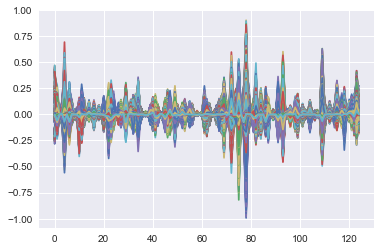

In [189]:
# looking at the score associate with each features in those games
# Calculate the features that are most common in those games to have high scores
WAS_features_w = df_train[numerical_cols].ix[ind_w].as_matrix()
WAS_features_r = df_train[numerical_cols].ix[ind_r].as_matrix()

SVM_coef = SVM.coef_.reshape(-1)
feature_score_w = WAS_features_w*SVM_coef
feature_score_r = WAS_features_r*SVM_coef
counts = {}
for i in range(0,WAS_features_r.shape[0]):
    for j in range(0,WAS_features_w.shape[0]):
        plt.plot(feature_score_w[j,:]-feature_score_r[i,:])
        where = np.where(np.absolute(feature_score_w[j,:]-feature_score_r[i,:]) > 0.3)
        for k in range(0,len(where[0])):
           if where[0][k] not in counts.keys():
             counts[where[0][k]] = 1 
           else:
             counts[where[0][k]] +=1
counts
list1 = (sorted(counts.items(), key=lambda x: x[1],reverse=True))
cd = [k  for (k,v) in list1]
cd

In [190]:
counts

{0: 76,
 4: 317,
 6: 3,
 10: 43,
 22: 30,
 23: 1,
 29: 1,
 34: 29,
 49: 1,
 69: 30,
 72: 198,
 75: 484,
 78: 1116,
 79: 1,
 82: 32,
 91: 3,
 93: 219,
 109: 307,
 115: 3,
 118: 1,
 123: 41}

In [191]:
print important_features[important_features.str.contains("HOME")]
print important_features[important_features.str.contains("AWAY")]
# the features that have hightest frequency in those games
df_train[numerical_cols].keys()[cd[0:6]]

Index([u'OPP_EFG_PCT_mean_HOME', u'STL_mean_HOME', u'NET_RATING_mean_HOME'], dtype='object')
Index([u'BLKA_mean_AWAY', u'OPP_FTA_RATE_mean_AWAY', u'AST_TOV_mean_AWAY',
       u'OPP_TOV_PCT_mean_AWAY'],
      dtype='object')


Index([u'STL_mean_HOME', u'AST_TOV_mean_AWAY', u'BLKA_mean_AWAY',
       u'AVG_SPREAD_mean', u'OPP_TOV_PCT_mean_AWAY',
       u'OPP_FTA_RATE_mean_AWAY'],
      dtype='object')

In [120]:
# Only taking the first few features in the important ones
X_train_less = df_train[numerical_cols][df_val[numerical_cols].keys()[cd[0:2]]].as_matrix()
X_val_less = df_val[numerical_cols][df_val[numerical_cols].keys()[cd[0:2]]].as_matrix()
print X_train_less.shape
# Without  the important ones
X_train_without = df_train[numerical_cols].drop(df_val[numerical_cols].keys()[cd[0:2]],1).as_matrix()
X_val_without = df_val[numerical_cols].drop(df_val[numerical_cols].keys()[cd[0:2]],1).as_matrix()
print X_train_without.shape

SVM_less_features = svm(C=0.001,loss="hinge")
SVM_less_features.fit(X_train_less,np.sign(y_train).reshape(-1))
print (SVM_less_features.predict(X_val_less) == np.sign(y_val).reshape(-1)).astype(float).mean()

SVM_less_features.fit(X_train_without,np.sign(y_train).reshape(-1))
print (SVM_less_features.predict(X_val_without) == np.sign(y_val).reshape(-1)).astype(float).mean()

(3635, 2)
(3635, 123)
0.686727122836
0.685078318219


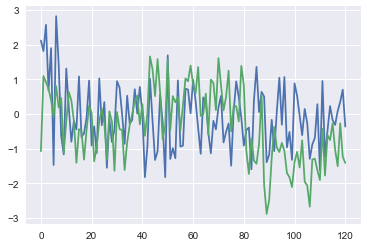

In [45]:
# to see relative relation
plt.plot(df_train[df_train["MATCHUP_HOME"].str[:3].str.contains("MIN")]["BLKA_mean_AWAY"].as_matrix()
         )
plt.plot(df_train[df_train["MATCHUP_HOME"].str[:3].str.contains("MIN")]["AVG_SPREAD_mean"].as_matrix()
         )

In [46]:
# Doing PCA on X both W/L and Spread
from sklearn.decomposition import PCA

X_DC = PCA(whiten=False)
X_train_PCA = X_DC.fit_transform(X_train)

X_DC_s = PCA(whiten=False)
X_train_spread_PCA = X_DC_s.fit_transform(X_train_spread)

In [217]:
# Keeping only the first few principle components
components_keep =4
X_train_PCA_keep = X_train_PCA[:,0:components_keep]
X_val_PCA_keep = X_DC.transform(X_val)[:,0:components_keep]

X_train_spread_PCA_keep = X_train_spread_PCA[:,0:components_keep]
X_val_spread_PCA_keep = X_DC_s.transform(X_val_spread)[:,0:components_keep]

In [218]:
# Train with only the first few PC
SVM_PCA = svm(C=0.004,penalty='l2',loss='hinge')
SVM_PCA.fit(X_train_PCA_keep,np.sign(y_train).reshape(-1))
(SVM_PCA.predict(X_val_PCA_keep) == np.sign(y_val).reshape(-1)).astype(int).mean()

0.64303380049464143

In [219]:
# Train with only the first few PC
SVM_spread_PCA = svm(C=0.1,penalty='l2',loss='hinge')
SVM_spread_PCA.fit(X_train_PCA_keep,y_train_spread)
(SVM_spread_PCA.predict(X_val_spread_PCA_keep) == y_val_spread).astype(int).mean()

0.58120362737015663

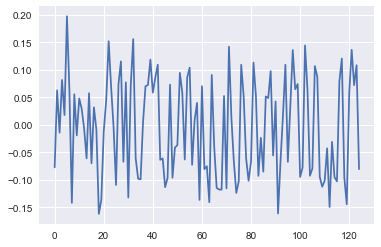

In [229]:
# plot the priciple component
num = 3
plt.plot(np.arange(0,X_DC.components_.shape[1]),X_DC.components_[num,:])

In [227]:
# See what's important element in the compenents
first_pca_feature = np.where(np.abs(X_DC.components_[num,:]) > 0.15)
df_train[numerical_cols].keys()[first_pca_feature]

Index([u'PCT_PTS_2PT_MR_mean_HOME', u'FTA_mean_HOME', u'FTA_mean_AWAY',
       u'PCT_PTS_2PT_mean_HOME', u'PCT_PTS_2PT_MR_mean_AWAY'],
      dtype='object')

In [210]:
# Using kernels after PCA
from sklearn.svm import SVC
kernel_svm = SVC(C=0.9,kernel = "rbf")
kernel_svm.fit(X_train_spread_PCA_keep,y_train_spread)

SVC(C=0.9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [118]:
(kernel_svm.predict(X_val_spread_PCA_keep)==y_val_spread).astype(int).mean()

0.58862324814509481

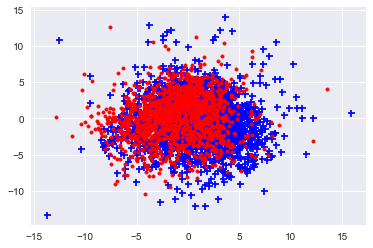

In [55]:
# Plot how prnciple component makes the problem more separable

x1_plus = X_train_PCA_keep[:,0][np.sign(y_train).reshape(-1)>=0]
x2_plus = X_train_PCA_keep[:,1][np.sign(y_train).reshape(-1)>=0]
x1_minus = X_train_PCA_keep[:,0][np.sign(y_train).reshape(-1)<0]
x2_minus = X_train_PCA_keep[:,1][np.sign(y_train).reshape(-1)<0]
plt.scatter(x1_plus,x2_plus,marker="+",c="b")
plt.scatter(x1_minus,x2_minus,marker=".",c="r")
plt.show()

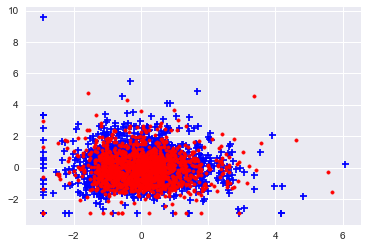

In [56]:
# comparision
x1_plus = X_train[:,0][np.sign(y_train).reshape(-1)>=0]
x2_plus = X_train[:,1][np.sign(y_train).reshape(-1)>=0]
x1_minus = X_train[:,0][np.sign(y_train).reshape(-1)<0]
x2_minus = X_train[:,1][np.sign(y_train).reshape(-1)<0]
plt.scatter(x1_plus,x2_plus,marker="+",c="b")
plt.scatter(x1_minus,x2_minus,marker=".",c="r")
plt.show()

In [89]:
from sklearn.ensemble import RandomForestClassifier
rf_spread = RandomForestClassifier(max_depth=10,max_features="sqrt")
rf_spread.fit(X_train_spread,y_train_spread)
(rf_spread.predict(X_train_spread)==y_train_spread).astype(int).mean()

0.85254470426409901